### Imports for Model

In [15]:
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from IPython import display
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import sys
FUENTES_DIR = "/lib"
sys.path.append(FUENTES_DIR)

DATOS_DIR = "data/"
import os
import requests
from datetime import date, datetime, timedelta

# Asegurar carpeta de datos
os.makedirs(DATOS_DIR, exist_ok=True)

# Parámetros de periodo: primer día de marzo 2025 hasta hoy
START_DATE = "2025-03-10"
END_DATE = date.today().isoformat()

# Ruta local para guardar el CSV crudo
raw_csv_path = os.path.join(DATOS_DIR, 'training.csv')

# URL remota a consultar
remote_url = f"http://localhost:8080/?start={START_DATE}&end={END_DATE}"

# Flags: forzar descarga o re-procesado (poner True para forzar)
FORCE_DOWNLOAD = False
FORCE_REPROCESS = False

if FORCE_DOWNLOAD and os.path.exists(raw_csv_path):
    os.remove(raw_csv_path)

print("remote_url: ", remote_url)

if not os.path.exists(raw_csv_path):
    print(f"Descargando datos de {remote_url} ...")
    try:
        resp = requests.get(remote_url, timeout=30)
        resp.raise_for_status()
        with open(raw_csv_path, 'wb') as f:
            f.write(resp.content)
        print(f"Guardado CSV en {raw_csv_path}")
    except Exception as e:
        print("Error descargando datos desde localhost:", e)
        raise
else:
    print(f"Archivo CSV crudo ya existe en {raw_csv_path}")

data = pd.read_csv(raw_csv_path)

remote_url:  http://localhost:8080/?start=2025-03-10&end=2025-11-01
Archivo CSV crudo ya existe en data/training.csv


### Preprocessing 

In [16]:

from lib.preprocessing import preprocess_data

data = preprocess_data(data)

# Separar features y labels
X = data.drop(columns=["consumption"])
T = data["consumption"]

data['daylight'].value_counts()

0   2025-03-10 03:00:00+00:00
1   2025-03-10 03:05:00+00:00
2   2025-03-10 03:10:00+00:00
3   2025-03-10 03:15:00+00:00
4   2025-03-10 03:20:00+00:00
Name: date, dtype: datetime64[ns, UTC]
0   2025-03-10 09:45:51+00:00
1   2025-03-10 09:45:51+00:00
2   2025-03-10 09:45:51+00:00
3   2025-03-10 09:45:51+00:00
4   2025-03-10 09:45:51+00:00
Name: sunrise_dt, dtype: datetime64[ns, UTC]
0   2025-03-10 22:18:04+00:00
1   2025-03-10 22:18:04+00:00
2   2025-03-10 22:18:04+00:00
3   2025-03-10 22:18:04+00:00
4   2025-03-10 22:18:04+00:00
Name: sunset_dt, dtype: datetime64[ns, UTC]


daylight
1    31727
0    27912
Name: count, dtype: int64

In [17]:
from lib.normalization import normalize_data

X_train, X_test, T_train, T_test, x_scaler, y_scaler = normalize_data(X, T, scaler_dir="models")

### Model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras import optimizers

# Modelo MLP con LeakyReLU y He initialization para capas ocultas
model = Sequential([
    Dense(64, kernel_initializer='he_normal', input_dim=X_train.shape[1]),
    LeakyReLU(alpha=0.1),
    Dense(32, kernel_initializer='he_normal'),
    LeakyReLU(alpha=0.1),
    Dense(16, kernel_initializer='he_normal'),
    LeakyReLU(alpha=0.1),
    Dense(1, activation='linear')  # salida lineal para regresión
])

optimizer = optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()


/home/mateo/temp/str/venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/mateo/temp/str/venv/lib/python3.13/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,777 (14.75 KB)

 Trainable params: 3,777 (14.75 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [19]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# --- Callbacks ---

# 1. Detiene el entrenamiento si no hay mejora después de 30 épocas
es = EarlyStopping(
    monitor='val_loss', 
    patience=75, 
    min_delta=0.0001,
    verbose=1
)

# 2. Reduce el Learning Rate si no hay mejora después de 5 épocas
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# 3. (RECOMENDADO) Guarda solo el MEJOR modelo durante el entrenamiento
# El archivo guardado siempre contendrá el modelo con la 'val_loss' más baja
model_checkpoint = ModelCheckpoint(
    filepath='models/best_energy_model.keras',  # Ruta donde guardar el mejor modelo
    monitor='val_loss',
    save_best_only=True,  # ¡Esta es la clave!
    verbose=1
)

# --- Verificación de GPU ---
if tf.config.list_physical_devices('GPU'):
  print("Entrenando en GPU.")
else:
  print("Advertencia: No se detectó GPU, se entrenará en CPU.")

# --- Entrenamiento ---
history = model.fit(
    X_train, T_train,
    batch_size=128,
    epochs=1000,
    verbose=1,
    validation_data=(X_test, T_test),
    callbacks=[es, reduce_lr, model_checkpoint]  # Añadimos el nuevo callback
)

# --- Post-entrenamiento ---
print("Entrenamiento finalizado.")

# -----------------------------------------------------------------
# CÓDIGO NUEVO PARA CARGAR Y EVALUAR EL MEJOR MODELO
# -----------------------------------------------------------------

# Opción 1: Ver el mejor 'val_loss' registrado en el historial
# Esto es rápido y te da el número exacto que buscaba ModelCheckpoint
best_val_loss = min(history.history['val_loss'])
print(f"\nLa mejor 'val_loss' registrada en el historial fue: {best_val_loss:.6f}")


# Opción 2: Cargar el modelo guardado y evaluarlo (MÉTODO RECOMENDADO)
# Esto confirma que el archivo se guardó bien y te da su 'loss' en los datos de prueba
print("Cargando el mejor modelo guardado por ModelCheckpoint...")

# Carga el modelo desde el archivo que guardó el callback
best_model = tf.keras.models.load_model('models/best_energy_model.keras')

print("Evaluando el mejor modelo con los datos de prueba...")

# .evaluate() devuelve la pérdida (loss) y cualquier otra métrica (ej. accuracy)
# La pérdida (loss) es siempre el primer elemento (índice 0)
results = best_model.evaluate(X_test, T_test, verbose=0)

print(f"Pérdida (Loss) del mejor modelo cargado: {results[0]:.6f}")

# Si tuvieras más métricas, por ejemplo 'MAE':
# print(f"MAE del mejor modelo cargado: {results[1]:.6f}")
# -----------------------------------------------------------------


# Ahora puedes usar 'best_model' para predicciones
# predictions = best_model.predict(X_test)

Entrenando en GPU.
Epoch 1/1000
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4901 - mae: 0.5174  
Epoch 1: val_loss improved from None to 0.14294, saving model to models/best_energy_model.keras

Epoch 1: val_loss improved from None to 0.14294, saving model to models/best_energy_model.keras
373/373 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2819 - mae: 0.3967 - val_loss: 0.1429 - val_mae: 0.2938 - learning_rate: 0.0010
Epoch 2/1000
373/373 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2819 - mae: 0.3967 - val_loss: 0.1429 - val_mae: 0.2938 - learning_rate: 0.0010
Epoch 2/1000
298/373 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 0.1294 - mae: 0.2800
Epoch 2: val_loss improved from 0.14294 to 0.10268, saving model to models/best_energy_model.keras

Epoch 2: val_loss improved from 0.14294 to 0.10268, saving model to models/best_energy_model.keras
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 0.1164 - mae: 0.2655 - val_loss: 0.1027 - val_mae: 0.2493 - learning_rate: 0.0010
Epoch 3/100

### Evaluation

Error al evaluar el modelo Keras: got an unexpected keyword argument 'squared'


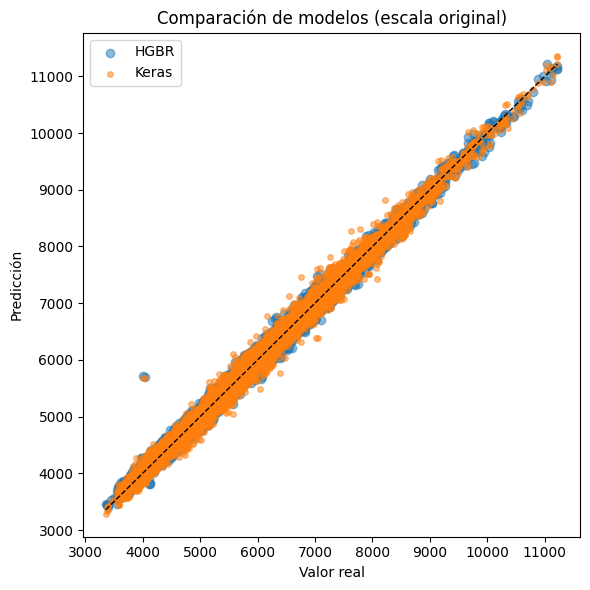

In [20]:
# Baseline tabular model: Gradient Boosting (sklearn)
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from joblib import dump
import numpy as np
import os

T_test_real = y_scaler.inverse_transform(T_test.reshape(-1, 1)).ravel()

hgb = HistGradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=None,
    max_iter=500,
    l2_regularization=0.0,
    early_stopping=True,
    validation_fraction=0.2,
    random_state=42,
)

hgb.fit(X_train, T_train)

# Guardar modelo HGBR para uso posterior
os.makedirs('models', exist_ok=True)
dump(hgb, 'models/hgb_model.joblib')

pred_hgb_scaled = hgb.predict(X_test)
pred_hgb = y_scaler.inverse_transform(pred_hgb_scaled.reshape(-1, 1)).ravel()
mae_hgb = mean_absolute_error(T_test_real, pred_hgb)
# rmse_hgb = mean_squared_error(T_test_real, pred_hgb, squared=False)
r2_hgb = r2_score(T_test_real, pred_hgb)

# print(f"HGBR -> MAE real: {mae_hgb:.3f} | RMSE real: {rmse_hgb:.3f} | R2 real: {r2_hgb:.3f}")

# Comparación rápida con el mejor modelo Keras en memoria (preferir `best_model` si existe)
keras_model = best_model if 'best_model' in globals() else (model if 'model' in globals() else None)

if keras_model is not None:
    try:
        pred_nn_scaled = keras_model.predict(X_test, verbose=0).reshape(-1)
        pred_nn = y_scaler.inverse_transform(pred_nn_scaled.reshape(-1, 1)).ravel()
        mae_nn = mean_absolute_error(T_test_real, pred_nn)
        rmse_nn = mean_squared_error(T_test_real, pred_nn, squared=False)
        r2_nn = r2_score(T_test_real, pred_nn)
        print(f"Keras -> MAE real: {mae_nn:.3f} | RMSE real: {rmse_nn:.3f} | R2 real: {r2_nn:.3f}")
    except Exception as e:
        print("Error al evaluar el modelo Keras:", e)
else:
    print("No hay modelo Keras en memoria para comparar.")

# Plot comparativo
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(T_test_real, pred_hgb, alpha=0.5, label='HGBR')
if 'pred_nn' in locals():
    plt.scatter(T_test_real, pred_nn, alpha=0.5, label='Keras', s=16)
minv, maxv = np.min(T_test_real), np.max(T_test_real)
plt.plot([minv, maxv], [minv, maxv], 'k--', lw=1)
plt.xlabel('Valor real')
plt.ylabel('Predicción')
plt.title('Comparación de modelos (escala original)')
plt.legend()
plt.tight_layout()
plt.show()


373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
Loss (escala normalizada): 0.0070, Métrica: 0.0622
MAE en escala original: 82.49
Loss (escala normalizada): 0.0070, Métrica: 0.0622
MAE en escala original: 82.49


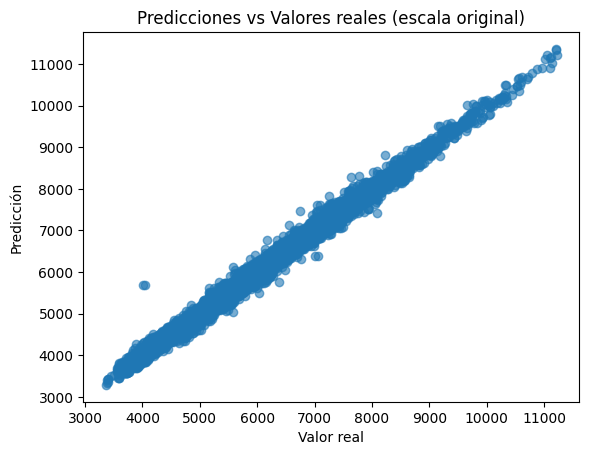

In [21]:
pred_scaled = model.predict(X_test)
pred = y_scaler.inverse_transform(pred_scaled).reshape(-1)
T_real = y_scaler.inverse_transform(T_test.reshape(-1, 1)).reshape(-1)

# Evaluación del modelo en escala normalizada
loss, metric = model.evaluate(X_test, T_test, verbose=0)
print(f"Loss (escala normalizada): {loss:.4f}, Métrica: {metric:.4f}")

# Métrica en escala original
mae_real = mean_absolute_error(T_real, pred)
print(f"MAE en escala original: {mae_real:.2f}")

plt.scatter(T_real, pred, alpha=0.6)
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Predicciones vs Valores reales (escala original)")
plt.show()

In [22]:
# Hardcoded inference example
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import load_model
from joblib import load

# Payload hardcodeado (proveído por el usuario)
payload = {
    "date": "2025-11-01T16:50Z",
    "temperature": 26.11,
    "humidity": 49,
    "rain": 0.0,
    "snow": 0.0,
    "pressure": 1013.0,
    "wind_speed": 2.47,
    "wind_direction": 358,
    "clouds": 100,
    "sunrise": 1761986859,
    "sunset": 1762035786,
    "working_day": False,
    "holiday": False,
}

# Construir DataFrame de una fila
row = {
    "date": [payload.get("date")],
    "temperature": [payload.get("temperature")],
    "humidity": [payload.get("humidity")],
    "rain": [payload.get("rain")],
    "snow": [payload.get("snow")],
    "pressure": [payload.get("pressure")],
    "wind_speed": [payload.get("wind_speed")],
    "wind_direction": [payload.get("wind_direction")],
    "clouds": [payload.get("clouds")],
    "sunrise": [int(payload.get("sunrise"))],
    "sunset": [int(payload.get("sunset"))],
    "working_day": [payload.get("working_day")],
    "holiday": [payload.get("holiday")],
}

df = pd.DataFrame(row)
# Aplicar preprocesamiento (usa la función definida en lib/preprocessing.py)
try:
    df_proc = preprocess_data(df)
except Exception as e:
    print("Error en preprocesamiento:", e)
    raise

# Preparar X para la inferencia
X_inf = df_proc.values

# Cargar modelo
model_path = os.path.join('models', 'energy_consumption_model.keras')
if not os.path.exists(model_path):
    print(f"Modelo no encontrado en {model_path}. Ejecuta la celda de training antes para crearlo.")
else:
    model = load_model(model_path)
    print("Modelo cargado.")

    y_scaler_local = None
    try:
        if 'x_scaler' in globals() and 'y_scaler' in globals():
            print("Usando escaladores presentes en memoria.")
            x_scaler_local = x_scaler
            y_scaler_local = y_scaler
        else:
            print("Cargando escaladores desde disco...")
            x_scaler_local = load(os.path.join('models', 'x_scaler.joblib'))
            y_scaler_local = load(os.path.join('models', 'y_scaler.joblib'))
        X_scaled = x_scaler_local.transform(X_inf)
    except Exception as e:
        print("Error al escalar features:", e)
        X_scaled = X_inf
        y_scaler_local = None

    pred_scaled = np.asarray(model.predict(X_scaled))
    if y_scaler_local is not None:
        pred = y_scaler_local.inverse_transform(pred_scaled).reshape(-1)
        print(f"Predicción de consumo energético: {pred[0]:.2f} unidades reales.")
    else:
        print("Predicción de consumo energético (escala del modelo):", pred_scaled.reshape(-1)[0])

0   2025-11-01 16:50:00+00:00
Name: date, dtype: datetime64[ns, UTC]
0   2025-11-01 08:47:39+00:00
Name: sunrise_dt, dtype: datetime64[ns, UTC]
0   2025-11-01 22:23:06+00:00
Name: sunset_dt, dtype: datetime64[ns, UTC]
Modelo cargado.
Usando escaladores presentes en memoria.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Predicción de consumo energético: 5290.17 unidades reales.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Predicción de consumo energético: 5290.17 unidades reales.


/home/mateo/temp/str/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
